In [1]:
ENV["GKS_ENCODING"] = "utf-8"
using NLsolve
using Plots
using BenchmarkTools
using Distributed
using IntervalArithmetic, IntervalRootFinding

include("/home/julian/Hamburg/LadderDGA/run.jl");

using 9 workers.
      From worker 7:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


      From worker 5:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 4:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 2:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 6:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 3:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 8:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 9:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


┌ Warning: ArgParse not working with jupyter notebooks
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:47
┌ Warning: Check U and Beta consistency in chi_dir/gamma_dir
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:48
┌ Info: Reading Inputs...
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:50
┌ Info: Reading Fortran Input, this can take several minutes.
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:95
┌ Info: Done Reading Gamma
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:109
┌ Info: Done Reading chi
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:111
┌ Info: loading from 
│   env.inputVars = vars.jld
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/helpers.jl:67
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/helpers.jl:77
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local 

[ Info: Done.


In [2]:
modelParams, simParams, env, impQ_sp, impQ_ch, GImp_pos, Σ_loc_pos, FUpDo  = LadderDGA.setup_LDGA("config.toml", false);
mP = LadderDGA.modelParams;
sP = LadderDGA.simParams;
qMultiplicity = LadderDGA.qMultiplicity;
function subtract_tail(inp, Ekin, mP)
    res = zeros(eltype(inp), size(inp)...)
    iωₙ2_full  = zeros(length(inp))
    for i in 1:length(inp)
        iωₙ2_full[i] = (LadderDGA.iω(i - ceil(Int64, length(inp)/2) - 0))^2
    end
    for n in 1:length(inp)
        if iωₙ2_full[n] != 0
            res[n] = inp[n] - (Ekin/iωₙ2_full[n])
        else
            res[n] = inp[n]
        end
    end
    return res
end

function subtract_tail!(inp, Ekin, mP)
    iωₙ2_full  = zeros(length(inp))
    for i in 1:length(inp)
        iωₙ2_full[i] = (LadderDGA.iω(i - ceil(Int64, length(inp)/2) - 0))^2
    end
    for n in 1:length(inp)
        if iωₙ2_full[n] != 0
            inp[n] -= (Ekin/iωₙ2_full[n])
        end
    end
end

[ Info: Reading Fortran Input, this can take several minutes.
[ Info: Done Reading Gamma
[ Info: Done Reading chi
┌ Info: loading from 
└   env.inputVars = "vars.jld"
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main.LadderDGA ~/Hamburg/LadderDGA/src/helpers.jl:77


subtract_tail! (generic function with 1 method)

In [3]:
tc = true
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω);
rχsp = nlQ_sp.χ[usable_ω,:];
rχch = nlQ_ch.χ[usable_ω,:];
rhs = tc ? mP.n * (1 - mP.n/2) : real(impQ_sp.χ_loc + impQ_ch.χ_loc)

χ_λ(χ, λ) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
nc = [0,1,2,3]
NW = floor(Int64, size(rχch, 1)/2)
ωmin = Int(floor(NW*1/4))
ωmax = NW 
W = LadderDGA.build_weights(ωmin, ωmax, [0,1,2,3])

iνₙ, GImp_pos    = LadderDGA.readGImp(LadderDGA.env.inputDir * "/gm_wim", only_positive=true)
ϵₖ, Vₖ, μ    = LadderDGA.read_anderson_parameters(LadderDGA.env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iνₙ[1:5000], ϵₖ, Vₖ, GImp_pos[1:5000], mP)
rem_full = -E_kin_ED*(mP.β*mP.β)/12

function construct_f!(F, λ, rhs)#default rhs χLocsp + χLocch or n/2 (1-n/2)
    χsp_λ = χ_λ(rχ_sp, λ[1])
    χch_λ = χ_λ(rχ_ch, λ[2]) 
    χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, qMultiplicity', dims=[2])[:,1]
    #, [1], tc, mP.β, weights=W)[1]  
    tmp =  (sum(subtract_tail(χupup, E_kin_ED, mP))+rem_full)/mP.β        
    F[1] = real(tmp - rhs)
end


function construct_f(λsp, λch, χsp, χch, qMultiplicity; mode=:naive ,rhs=0.5) 
    χch_λ = χ_λ(χch, λch)
    χsp_λ = χ_λ(χsp, λsp)
    χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, qMultiplicity', dims=[2])[:,1]
    tmp = 0.0
    if mode == :naive
        tmp = sum(χupup)/mP.β
    elseif mode == :sub
        tmp =  (sum(subtract_tail(χupup, E_kin_ED, mP)) + rem_full)/mP.β 
    elseif mode == :fit
        tmp =  LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=W)[1]          
    else
        tmp =  LadderDGA.sum_freq(subtract_tail(χupup, E_kin_ED, mP), [1], true, mP.β, correction=rem_full, weights=W)[1]
    end
    res1 = real(tmp - rhs)
    return res1
end

construct_f (generic function with 1 method)

# Condition 1

## Testing NLsolve vs Roots

In [4]:
upper_lim = 1.2
testf!(F,λ) = F[1]=construct_f(λ[1], 0.0, rχsp, rχch, qMultiplicity, rhs=rhs)
testf(λsp) = construct_f(λsp, 0.0, rχsp, rχch, qMultiplicity, rhs=rhs)
res_nls = nlsolve(testf!, [upper_lim], autodiff = :forward)
Xsp = @interval(0.0,upper_lim)
res_roots = roots(testf, Xsp, Newton, 1e-10)
max_int = mid(maximum(interval.(res_roots)))

0.08646669822913558

## compute λsp(λch) (NLsolve)

21 of 21

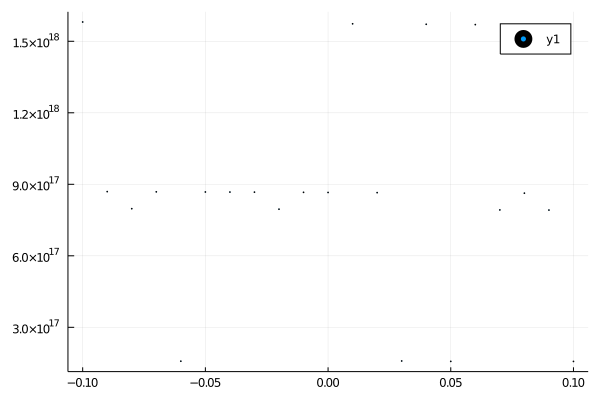

In [5]:
λch_range = -0.1:0.01:0.1
spOfch_max_nl = zeros(size(λch_range))
for (λi,λchi) in enumerate(λch_range)
    testf!(F,λ) = F[1]=construct_f(λ[1], λchi, rχsp, rχch, qMultiplicity, rhs=rhs)
    res = nlsolve(testf!, [1.2], autodiff = :forward)
    spOfch_max_nl[λi] = res.zero[1]
    print("\r$λi of $(length(λch_range))")
end
plot(λch_range,spOfch_max_nl, seriestype=:scatter, markersize=0.8)

## compute λsp(λch) (Roots)

In [ ]:
Xsp = @interval(0.01,0.1)
Xch = @interval(-2,2)
λch_range_c1 = -6.0:0.3:6.0
λch_range2_c1 = -15:0.5:15
spOfch_max_int_c1 = zeros(4,size(λch_range_c1)...)
spOfch2_max_int_c1 = zeros(4,size(λch_range2_c1)...)
spOfch3_max_int_c1 = zeros(4,size(λch_range2_c1)...)

#for (λi,λchi) in enumerate(λch_range_c1)
#    testf(λsp) = construct_f(λsp, λchi, real.(χsp), real.(χch), qMultiplicity, rhs=real(χLocsp + χLocch))
#    res_internal = roots(testf, Xsp, Newton, 1e-5)
#    max_int = maximum(interval.(res_internal))
#    spOfch_max_int_c1[λi] = mid(max_int)
#    print("\r", λi, " of ", length(λch_range))
#end
for (mi,m) in enumerate([:naive, :sub, :fit, :both])
    println("\rmode: ", m)
    for (λi,λchi) in enumerate(λch_range2_c1)
        testf(λsp) = construct_f(λsp, λchi, rχsp, rχch, qMultiplicity, mode=m, rhs=rhs)
        res_internal = roots(testf, Xsp, Newton, 1e-5)
        max_int = maximum(interval.(res_internal))
        spOfch2_max_int_c1[mi,λi] = mid(max_int)
        print("\r", rpad(λi,length(string(length(λch_range2_c1)))), " of ", length(λch_range2_c1))
    end
end

#for (λi,λchi) in enumerate(λch_range2_c1)
#    testf(λsp) = construct_f(λsp, λchi, rχsp, rχch, qMultiplicity, rhs=rhs)
#    res_internal = roots(testf, Xsp, Newton, 1e-5)
#    max_int = maximum(interval.(res_internal))
#    spOfch3_max_int_c1[λi] = mid(max_int)
#    print("\r", λi, " of ", length(λch_range2_c1))
#end

mode: naive
mode: sub
mode: fit


In [ ]:
plot(λch_range2_c1, spOfch2_max_int_c1[1,:], label="roots, naive", xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:10:end],seriestype = :scatter, markersize=1.8)
plot!(λch_range2_c1, spOfch2_max_int_c1[2,:], label="roots, tail sub", xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:10:end],seriestype = :scatter, markersize=1.8)
plot!(λch_range2_c1, spOfch2_max_int_c1[3,:], label="roots, fit", xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:10:end],seriestype = :scatter, markersize=1.8)
plot!(λch_range2_c1, spOfch2_max_int_c1[4,:], label="roots, both", xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:10:end],seriestype = :scatter, markersize=1.8)
savefig("roots_tc_EoMtc.pdf")
#plot!(λch_range, spOfch_max_nl, label="NLsolve", seriestype = :scatter, markersize=0.8)

In [ ]:
using JLD
JLD.save("./roots_tc_EoMtc.jld","roots",spOfch2_max_int_c1)

In [15]:
spOfch2_max_int_c1_tc = JLD.load("roots_tc.jld")["rootstc"]

4×61 Array{Float64,2}:
 0.0868065  0.0865471  0.0869615  …  0.0871296  0.0871278  0.087126
 0.0868218  0.0865476  0.0870464     0.0872882  0.0873045  0.0873037
 0.0869157  0.0865998  0.0871343     0.0873814  0.0873803  0.0873793
 0.0869157  0.0865998  0.0871356     0.0873818  0.0873807  0.0873796

In [ ]:
plot(λch_range2_c1[1:end], spOfch2_max_int_c1[1:end], xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:5:end],seriestype = :scatter, markersize=0.8)
plot!(λch_range2_c1[1:end], spOfch3_max_int_c1[1:end], xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:5:end],seriestype = :scatter, markersize=0.8)
#savefig("max_lambdasp_of_lambdach.pdf")

# Condition 2

In [ ]:
function cond_Epot2(λsp, λch, nlQ_sp, nlQ_ch; rhs)
    #println("///1")
    usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
    χsp_λ = χ_λ(nlQ_sp.χ, λsp)
    χch_λ = χ_λ(nlQ_ch.χ, λch)
    #println("///1.1")
    nlQ_sp_λ = LadderDGA.NonLocalQuantities_Interval(χsp_λ, nlQ_sp.γ, nlQ_sp.usable_ω, λsp)
    nlQ_ch_λ = LadderDGA.NonLocalQuantities_Interval(χch_λ, nlQ_ch.γ, nlQ_ch.usable_ω, λch)
    #println("///2")
    Σ_ladder = LadderDGA.calc_Σ(nlQ_sp_λ, nlQ_ch_λ, bubble, LadderDGA.GLoc_fft, 
                       LadderDGA.qIndices, usable_ω, sP.Nk)
    println("///3")
    Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc_pos[eachindex(Σ_ladderLoc)]
    mP.U * sum(real.(χch_λ[usable_ω,:] .- χsp_λ[usable_ω,:])) ./ (mP.β*(sP.Nk^mP.D)) - rhs
end


function cond_Epot2_overview2(λsp, λch, nlQ_sp, nlQ_ch; rhs)
    χsp_λ = SharedArray(χ_λ(nlQ_sp.χ, λsp))
    χch_λ = SharedArray(χ_λ(nlQ_ch.χ, λch))
    usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
    nlQ_sp_λ = LadderDGA.NonLocalQuantities(χsp_λ, nlQ_sp.γ, usable_ω, λsp)
    nlQ_ch_λ = LadderDGA.NonLocalQuantities(χch_λ, nlQ_ch.γ, usable_ω, λch)
    println("///3.1")
    Σ_ladder = LadderDGA.calc_Σ(nlQ_sp_λ, nlQ_ch_λ, bubble, LadderDGA.GLoc_fft, 
                       LadderDGA.qIndices, usable_ω, 1:sP.n_iν, sP.Nk)
    println("///3.3")
    Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ LadderDGA.Σ_loc_pos[eachindex(Σ_ladderLoc)]
    #Σ_ladder_corrected, Σ_ladderLoc
    println("res = ", mP.U * sum(real.(χch_λ[usable_ω,:] .- χsp_λ[usable_ω,:])) ./ (mP.β*(sP.Nk^mP.D)))
    E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder_corrected, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP)
    GC.gc()
    println("using ", nprocs(), " workers.")
    return [mP.U * sum(real.(χch_λ[usable_ω,:] .- χsp_λ[usable_ω,:])) ./ (mP.β*(sP.Nk^mP.D));E_Pot]
end

function cond_Epot_overview3(λsp, λch, nlQ_sp, nlQ_ch)
    res_roots, Σ_ladder2, lhs, E_pot = LadderDGA.calc_E_pot_cond(λsp, λch, nlQ_sp, nlQ_ch, bubble, 
                         LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                         LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                         LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                         mP, sP, false, find_root=false);
    return lhs, E_pot
end

In [ ]:
rhs_overview = Array{Float64,2}(undef, length(λch_range_c2),length(λsp_range_c2));
lhs_overview = Array{Float64,2}(undef, length(λch_range_c2),length(λsp_range_c2));

In [ ]:
λch_range_c2 = -0.0:0.01:0.5
#λch_range2_c2 = -20:0.5:20
#λch_range = -4.0:0.5:4.0
λsp_range_c2 = -1:0.1:1
#λch_range = -4.0:0.05:4.0
#λsp_range = 0.022:0.00001:0.023


overview_f(λsp, λch) = LadderDGA.cond_Epot2_overview(λsp, λch, nlQ_sp, nlQ_ch,rhs=E_pot_ED)
for i in (1:length(λch_range_c2))
    λch_i = λch_range_c2[i]
    for (j,λsp_i) in enumerate(λsp_range_c2)
        lhs, E_pot = cond_Epot_overview3(λsp_i, λch_i, nlQ_sp, nlQ_ch)
        lhs_overview[i,j] = lhs
        rhs_overview[i,j] = E_pot
        print("\r", i, " ", j, " = ",i*j," of ",length(λch_range_c2)," x ",length(λsp_range_c2), " = ", length(λch_range_c2)*length(λsp_range_c2))   
    end
    GC.gc()
    println("(out)using ", nprocs(), " workers.")
end

In [49]:
#save("cond_2_data.jld", "lhs", lhs_overview ./ 2, "rhs", rhs_overview)
using JLD
save("rhs_lhs_tc_EoMtc_2.jld", "lhs", lhs_overview[1:59,:], "rhs", rhs_overview[1:59,:])

In [36]:
lhs_overview[1:59,:]

59×21 Array{Float64,2}:
 0.00415942  0.00577827  0.00785762  0.0107314  …  -0.00936894  -0.00867987
 0.00415748  0.00577634  0.00785569  0.0107295     -0.00937087  -0.0086818
 0.00415555  0.00577441  0.00785376  0.0107275     -0.0093728   -0.00868373
 0.00415362  0.00577248  0.00785183  0.0107256     -0.00937473  -0.00868566
 0.0041517   0.00577055  0.0078499   0.0107237     -0.00937665  -0.00868759
 0.00414978  0.00576863  0.00784798  0.0107218  …  -0.00937858  -0.00868951
 0.00414785  0.00576671  0.00784606  0.0107198     -0.0093805   -0.00869143
 0.00414594  0.00576479  0.00784414  0.0107179     -0.00938242  -0.00869335
 0.00414402  0.00576287  0.00784222  0.010716      -0.00938433  -0.00869527
 0.00414211  0.00576096  0.00784031  0.0107141     -0.00938625  -0.00869718
 0.00414019  0.00575905  0.0078384   0.0107122  …  -0.00938816  -0.00869909
 0.00413828  0.00575714  0.00783649  0.0107103     -0.00939007  -0.008701
 0.00413638  0.00575523  0.00783458  0.0107084     -0.00939197  -0.

In [37]:
rhs_overview[1:59,:]

59×21 Array{Float64,2}:
 0.37462   0.407645  0.454561  0.528035  …  0.140473  0.155299  0.168042
 0.374627  0.407652  0.454567  0.528042     0.140476  0.155303  0.168046
 0.374634  0.407658  0.454574  0.528048     0.14048   0.155306  0.168049
 0.374641  0.407665  0.454581  0.528055     0.140483  0.15531   0.168052
 0.374648  0.407672  0.454587  0.528062     0.140487  0.155313  0.168056
 0.374655  0.407679  0.454594  0.528068  …  0.14049   0.155317  0.168059
 0.374662  0.407686  0.454601  0.528075     0.140494  0.15532   0.168063
 0.374669  0.407692  0.454608  0.528081     0.140497  0.155324  0.168066
 0.374676  0.407699  0.454614  0.528088     0.140501  0.155327  0.168069
 0.374682  0.407706  0.454621  0.528095     0.140504  0.15533   0.168073
 0.374689  0.407713  0.454628  0.528101  …  0.140508  0.155334  0.168076
 0.374696  0.407719  0.454634  0.528108     0.140511  0.155337  0.16808
 0.374703  0.407726  0.454641  0.528115     0.140515  0.155341  0.168083
 ⋮                          

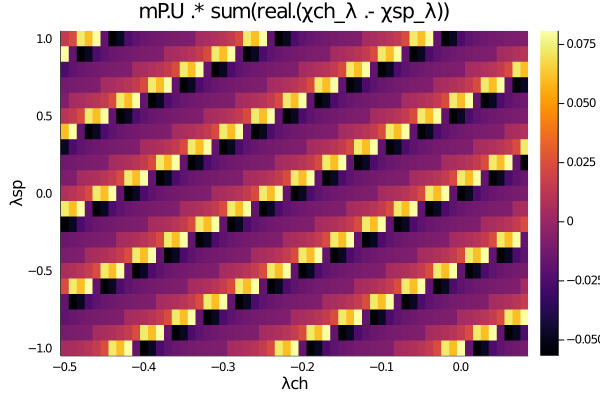

In [42]:
heatmap(λch_range_c2[1:59], λsp_range_c2, lhs_overview[1:59,:], xlabel="λch", ylabel="λsp", title="mP.U .* sum(real.(χch_λ .- χsp_λ))")
#savefig("lhs.pdf")

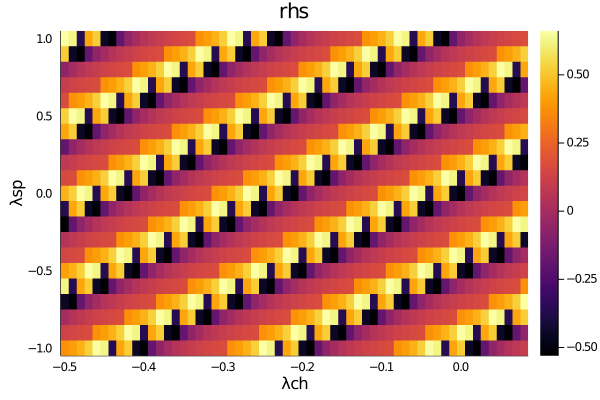

In [44]:
heatmap(λch_range_c2[1:59], λsp_range_c2, rhs_overview[1:59,:], xlabel="λch", ylabel="λsp", title="rhs")
#savefig("rhs_tc.pdf")

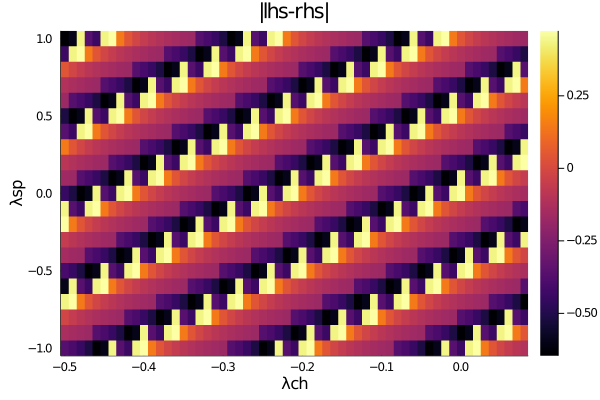

In [47]:
heatmap(λch_range_c2[1:59], λsp_range_c2, lhs_overview[1:59,:] .- rhs_overview[1:59,:], xlabel="λch", ylabel="λsp", title="|lhs-rhs|")
#savefig("lhs_rhs_EoM_tc.pdf")

In [104]:
writedlm("cond2.csv",  lhs_overview .- rhs_overview, ' ')

In [141]:
arr_tmp = lhs_overview .- rhs_overview
open("cond2_2.txt", "w") do f
    for i in 1:size(arr_tmp,1)
        for j in 1:size(arr_tmp,2)
            @printf(f, "  %18.10f  %18.10f  %18.10f\n", λch_range_c2[i] , λsp_range_c2[j], arr_tmp[i,j])

            #str = string(λch_range_c2[i] ,"\t", λsp_range_c2[j] , "\t", arr_tmp[i,j], "\n")
            #write(io, str)
            #println(str)
        end
        @printf(f, "\n")
    end
end

In [133]:
abs.(arr_tmp)[:,25:end]

61×27 Array{Float64,2}:
 0.245388  0.000368725  0.13659   1.81385  …  0.22722   0.228013  0.228812
 0.24543   0.0003051    0.136805  1.81387     0.227245  0.228039  0.228838
 0.245472  0.000242123  0.137018  1.81388     0.227271  0.228064  0.228864
 0.245513  0.000179786  0.137228  1.8139      0.227296  0.228089  0.228889
 0.245554  0.000118075  0.137436  1.81392     0.227321  0.228114  0.228913
 0.245594  5.6982e-5    0.137642  1.81394  …  0.227345  0.228139  0.228938
 0.245634  3.505e-6     0.137845  1.81396     0.22737   0.228163  0.228962
 0.245673  6.33957e-5   0.138047  1.81398     0.227394  0.228187  0.228986
 0.245712  0.0001227    0.138246  1.81399     0.227418  0.228211  0.22901
 0.245751  0.000181428  0.138443  1.81401     0.227441  0.228235  0.229033
 0.245789  0.000239589  0.138638  1.81403  …  0.227465  0.228258  0.229057
 0.245826  0.000297191  0.138831  1.81404     0.227488  0.228281  0.22908
 0.245864  0.000354245  0.139022  1.81406     0.227511  0.228304  0.229102
 ⋮ 

In [138]:
abs.(arr_tmp)[3,26]

0.0002421233419692692

In [140]:
c2_zeros_ind = findall(x -> x < 0.005, abs.(arr_tmp))

61-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 26)
 CartesianIndex(2, 26)
 CartesianIndex(3, 26)
 CartesianIndex(4, 26)
 CartesianIndex(5, 26)
 CartesianIndex(6, 26)
 CartesianIndex(7, 26)
 CartesianIndex(8, 26)
 CartesianIndex(9, 26)
 CartesianIndex(10, 26)
 CartesianIndex(11, 26)
 CartesianIndex(12, 26)
 CartesianIndex(13, 26)
 ⋮
 CartesianIndex(50, 26)
 CartesianIndex(51, 26)
 CartesianIndex(52, 26)
 CartesianIndex(53, 26)
 CartesianIndex(54, 26)
 CartesianIndex(55, 26)
 CartesianIndex(56, 26)
 CartesianIndex(57, 26)
 CartesianIndex(58, 26)
 CartesianIndex(59, 26)
 CartesianIndex(60, 26)
 CartesianIndex(61, 26)

In [120]:
λsp_range_c2[26]

0.095

In [126]:
λch_range_c2[1:25]

-3.0:0.1:-0.6

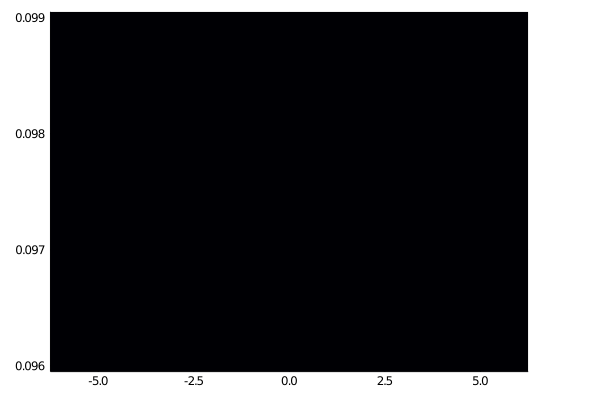

GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


In [47]:
heatmap(λch_range_c2, λsp_range_c2, sign.(lhs_overview .- rhs_overview))

In [135]:
spOfch_max_int_c2 = zeros(length(spOfch_max_int))
spOfch2_max_int_c2 = zeros(length(spOfch2_max_int))


for (λi,(λchi, λspi)) in enumerate(zip(λch_range_c1, spOfch_max_int_c1))
    E_Poti = cond_Epot2(λspi, λchi, χsp, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                       Σ_loc, Σ_ladderLoc_cut, ϵkGrid_red, qIndices, usable_ω, 1:simParams.n_iν, 
                       modelParams, simParams)
    spOfch_max_int_c2[λi] = E_Poti
    print("\r", λi, " of ", length(spOfch2_c2_max_int))
end

for (λi,(λchi, λspi)) in enumerate(zip(λch_range2_c1, spOfch2_max_int_c1))
    E_Poti = cond_Epot2(λspi, λchi, χsp, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                       Σ_loc, Σ_ladderLoc_cut, ϵkGrid_red, qIndices, usable_ω, 1:simParams.n_iν, 
                       modelParams, simParams)
    spOfch2_max_int_c2[λi] = E_Poti
    print("\r", λi, " of ", length(spOfch2_c2_max_int))
end

81 of 81

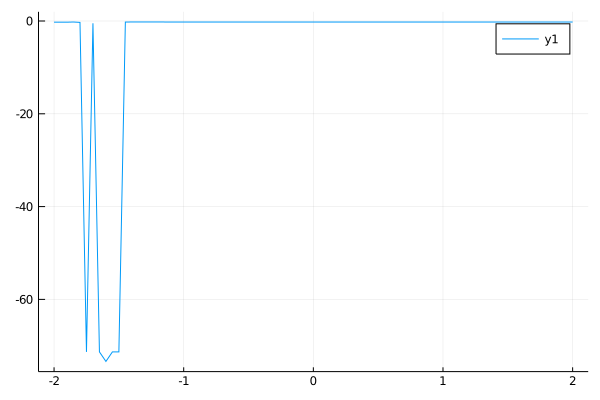

In [138]:
plot(λch_range_c1, spOfch2_max_int_c2)

In [144]:
using Roots

Xsp = @interval(0.09,0.1)
Xch = @interval(-2,2)
λch_range_c2 = -2:0.05:2
λch_range2_c2 = -20:0.5:20
spOfch_max_int_c2 = zeros(size(λch_range_c1))
spOfch2_max_int_c2 = zeros(size(λch_range2_c1))

for (λi,λchi) in enumerate(λch_range_c1)
    testf2(λsp) = cond_Epot2_r(λsp, λchi, χsp, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                       Σ_loc, Σ_ladderLoc_cut, ϵkGrid, qIndices, usable_ω, 1:simParams.n_iν, 
                       modelParams, simParams)
    spOfch_max_int_c2[λi] = mid(max_int)
    print("\r", λi, " of ", length(λch_range))
end

for (λi,λchi) in enumerate(λch_range2_c1)
    testf2(λsp) = cond_Epot2_r(λsp, λchi, χsp, χch, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                   Σ_loc, Σ_ladderLoc_cut, ϵkGrid, qIndices, usable_ω, 1:simParams.n_iν, 
                   modelParams, simParams)
    spOfch2_max_int_c2[λi] = mid(max_int)
    print("\r", λi, " of ", length(λch_range2))
end

81 of 81

# Both conditions

In [156]:
function cond_both(λsp, λch, χsp, χch, trilexsp, trilexch, bubble, GLoc, GLoc_fft, FUpDo, 
                   Σ_loc, Σ_ladderLoc, rhs, ϵkGrid, qIndices, usable_ω, usable_ν, mP, sP)
    χsp_λ = χ_λ(χsp, λsp)[usable_ω,:]
    χch_λ = χ_λ(χch, λch)[usable_ω,:]
    println(λsp, " ", λch)
    χsp_λ2 = typeof(λsp) <: Interval ? χ_λ(χsp, mid(λsp)) : χ_λ(χsp, λsp)
    χch_λ2 = typeof(λch) <: Interval ? χ_λ(χch, mid(λch)) : χ_λ(χch, λch)
    Σ_λ = calc_DΓA_Σ_fft(χsp_λ2, χch_λ2, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                         ϵkGrid, qIndices, (1:(2*simParams.n_iω+1)), 1:simParams.n_iν, simParams.Nk,
                         modelParams, simParams, simParams.tail_corrected)
    Σ_λ_corrected = Σ_λ .- Σ_ladderLoc .+ Σ_loc[1:length(Σ_ladderLoc)]
    r1 =  sum(sum(χch_λ .+ χsp_λ, dims=1)[1,:] .* qMultiplicity) ./ (modelParams.β*sum(qMultiplicity)) - rhs
    E_Pot = calc_E_Pot(Σ_λ_corrected, ϵkGrid, mP, sP)
    r2 = mP.U * sum(real.(χch_λ .- χsp_λ)) ./ (mP.β*(sP.Nk^mP.D)) - E_Pot
    return SVector(r1, r2)
end


function cond_both_r!(F, λ, χsp, χch, trilexsp, trilexch, bubble, GLoc, GLoc_fft, FUpDo, 
                   Σ_loc, Σ_ladderLoc, rhs, ϵkGrid, qIndices, usable_ω, usable_ν, mP, sP)
    χsp_λ = χ_λ(χsp, λ[1])[usable_ω,:]
    χch_λ = χ_λ(χch, λ[2])[usable_ω,:]
    println(λ)
    χsp_λ2 = typeof(λ[1]) <: Interval ? χ_λ(χsp, mid(λ[1])) : χ_λ(χsp, λ[1])
    χch_λ2 = typeof(λ[2]) <: Interval ? χ_λ(χch, mid(λ[2])) : χ_λ(χch, λ[2])
    Σ_λ = calc_DΓA_Σ_fft(χsp_λ2, χch_λ2, trilexsp, trilexch, bubble, GLoc_fft, FUpDo, 
                         ϵkGrid, qIndices, (1:(2*simParams.n_iω+1)), 1:simParams.n_iν, simParams.Nk,
                         modelParams, simParams, simParams.tail_corrected)
    Σ_λ_corrected = Σ_λ .- Σ_ladderLoc .+ Σ_loc[1:length(Σ_ladderLoc)]
    E_Pot = calc_E_Pot(Σ_λ_corrected, ϵkGrid, mP, sP)
    F[1] = sum(sum(real.(χch_λ .+ χsp_λ), dims=1)[1,:] .* qMultiplicity) ./ (modelParams.β*sum(qMultiplicity)) - rhs
    F[2] = mP.U * sum(real.(χch_λ .- χsp_λ)) ./ (mP.β*(sP.Nk^mP.D)) - E_Pot
end

cond_both_r! (generic function with 1 method)

In [149]:
Xsp = @interval(0.09,0.1)
Xch = @interval(-2,2)
λch_range_c2 = -0.2:0.05:0.2 #0.2
λch_range2_c2 = -20:0.2:20 #0.2
spOfch_max_int_c2 = zeros(size(λch_range_c2))
testf3((λsp, λch)) = cond_both(λsp, λch, rχsp, rχch, trilexsp, trilexch, bubble, GLoc, GLoc_fft, FUpDo, 
                           Σ_loc, Σ_ladderLoc_full, real(χLocsp + χLocch), ϵkGrid, qIndices, usable_ω, 1:simParams.n_iν, 
                           modelParams, simParams)
res_internal = roots(testf3, Xsp × Xch, IntervalRootFinding.Bisection, 1e-2)

BoundsError: BoundsError: attempt to access 9×56 Array{Interval{Float64},2} at index [1:61, Base.Slice(Base.OneTo(56))]

In [36]:
nh       = ceil(Int64, size(usable_ω,1)/2)
χsp_min    = -minimum(real.(1 ./ χsp[usable_ω[nh],:]))
χch_min    = -minimum(real.(1 ./ χch[usable_ω[nh],:]))
println("χsp_min: $(χsp_min)\nχch_min: $(χch_min)")

χsp_min: 0.02205518884088588
χch_min: -17.932849444809275


In [66]:
Xsp = @interval(-2,2)
Xch = @interval(-20,1)
λsp_range = -1:0.02:1
resi = zeros(size(λsp_range))
resi2 = zeros(size(λsp_range))
rχ_sp = real.(χsp[usable_ω,:])
rχ_ch = real.(χch[usable_ω,:])
for (λi,λsp) in enumerate(λsp_range)
    testf(λch) = construct_f(λsp, λch, rχ_sp, rχ_ch, qMultiplicity, rhs=real(χLocsp + χLocch))
    res_internal = roots(testf, Xch, Newton, 1e-8)
    max_int = maximum(interval.(res_internal))
    min_int = minimum(interval.(res_internal))
    resi[λi] = mid(max_int)
    resi2[λi] = mid(min_int)
    print("\r", λi, " of ", length(λsp_range))
end

101 of 101

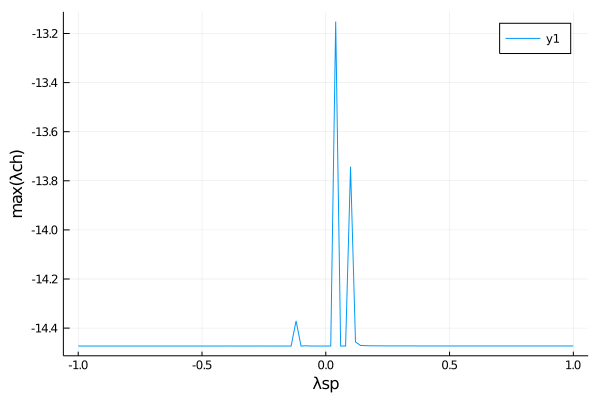

In [67]:
plot(λsp_range[1:end], resi[1:end], xlabel="λsp", ylabel="max(λch)")
#savefig("max_lambdach_of_lambdasp.pdf")

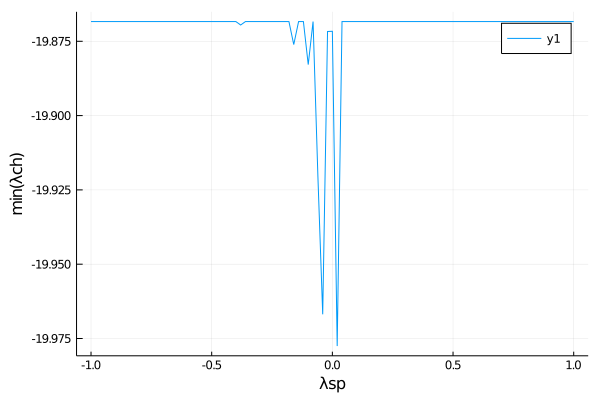

In [68]:
plot(λsp_range[1:end], resi2[1:end], xlabel="λsp", ylabel="min(λch)")
#savefig("min_lambdach_of_lambdasp.pdf")

In [70]:
λch_range2 = -0.6:0.01:0.6
λsp_range2 = -0.5:0.01:0.5
res2 = zeros(length(λch_range2), length(λsp_range2))
ωrange = intersect(usable_ch, usable_sp)

for (i,λch_i) in enumerate(λch_range2)
    for (j,λsp_i) in enumerate(λsp_range2)
        res2[i,j] = construct_f( (λch_i, λsp_i),χch[ωrange,:], χsp[ωrange,:])  
    end
end

MethodError: MethodError: no method matching construct_f(::Tuple{Float64,Float64}, ::Array{Complex{Float64},2}, ::Array{Complex{Float64},2})
Closest candidates are:
  construct_f(::Any, ::Any, ::Any, !Matched::Any, !Matched::Any; rhs) at In[21]:18

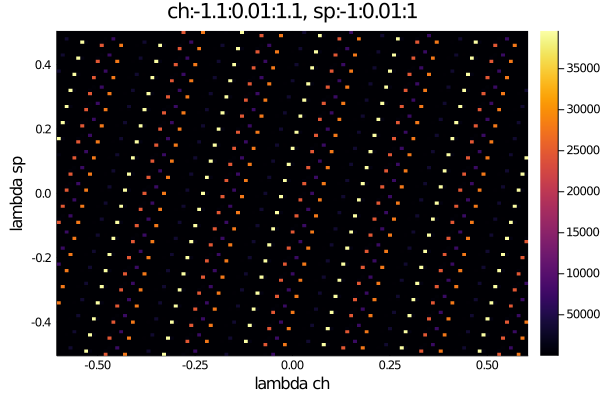

In [217]:
heatmap(λch_range2, λsp_range2, (res2 .- 0).^4, xlabel = "lambda ch", ylabel = "lambda sp", title="ch:-1.1:0.01:1.1, sp:-1:0.01:1")

In [349]:
χ_min_ch    = -minimum(1 ./ real.(χch[ceil(Int64,size(χch,1)/2),:]))
χ_min_sp    = -minimum(1 ./ real.(χsp[ceil(Int64,size(χch,1)/2),:]))
println(χ_min_ch, ", ", χ_min_sp)

-14.473154939042681, 0.09308725343569026


In [375]:
Xint = 0..1.1
fsp(λsp) =  construct_f(0.0, λsp, χch[ωrange,:], χsp[ωrange,:], qMultiplicity, rhs = rhs)
res_sp = IntervalRootFinding.roots(fsp, Xint, Newton, 1e-5)  
println(sort(interval.(res_sp)))
println(maximum(interval.(res_sp)))

Interval{Float64}[[0.0103389, 0.010339], [0.0143941, 0.0144021], [0.0225144, 0.0225147], [0.0236029, 0.023608], [0.0289026, 0.0289106], [0.0387014, 0.0387016], [0.049588, 0.0495966], [0.0626939, 0.062694], [0.0709535, 0.0709617], [0.0833816, 0.0833819], [0.0930821, 0.0930906], [0.0952014, 0.0952076]]
[0.0952014, 0.0952076]


In [377]:
Xint = (χ_min_ch-0.5)..(χ_min_ch+0.5)
χ_min_ch = -minimum(1 ./ real.(χch[floor(Int64,size(χch,1)/2),:]))
fch(λch) =  construct_f(λch, 0.0, χch[ωrange,:], χsp[ωrange,:], qMultiplicity, rhs = rhs)
res_ch = IntervalRootFinding.roots(fch, Xint)  
println(sort(interval.(res_ch)))
println(maximum(interval.(res_ch)))

Interval{Float64}[[227.512, 227.513], [227.514, 227.515]]
[227.514, 227.515]


In [333]:
Xint = -2..2
λch_range = -15:0.1:-14
χ_min_ch    = -minimum(1 ./ real.(χch[floor(Int64,size(χch,1)/2),:]))
res = zeros(length(λch_range))
for (i,λch_i) in enumerate(-15:0.1:-14)
    fsp_int(λsp) =  construct_f(λch_i, λsp, χch[ωrange,:], χsp[ωrange,:], qMultiplicity, rhs = rhs)
    res_sp = IntervalRootFinding.roots(fsp_int, Xint, Newton, 1e-3)
    res_sp_sort = sort(interval.(res_sp))
    println(res_sp_sort)
    res[i] = mid(maximum(interval.(res_sp)))
    println(i)
end

Interval{Float64}[[-0.656976, -0.65666], [-0.645462, -0.644907], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347508], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.30

Interval{Float64}[[-0.617177, -0.617105], [-0.614462, -0.614187], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.348871, -0.347909], [-0.34791, -0.347435], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.305545, -0.304552], [-0.3

Interval{Float64}[[-0.615255, -0.614461], [-0.6068, -0.606756], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.348871, -0.347909], [-0.347414, -0.346933], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.305545, -0.304552], [-0.30

Interval{Float64}[[-0.668343, -0.667733], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347527], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.305545, -0.304552], [-0.3

Interval{Float64}[[-0.709881, -0.709333], [-0.707951, -0.707624], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347586], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.3

Interval{Float64}[[-0.738249, -0.738186], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400529, -0.400028], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347621], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.3

In [334]:
res

11-element Array{Float64,1}:
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237

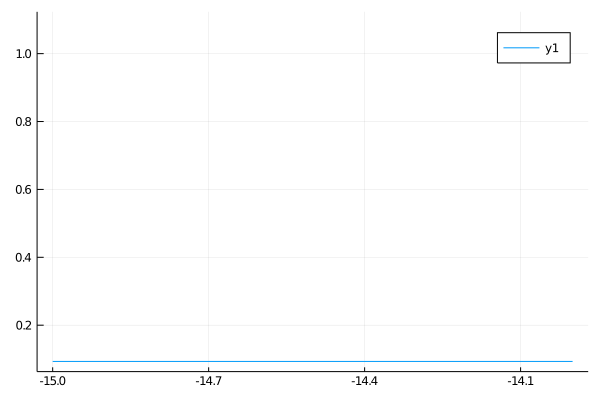

In [335]:
plot(λch_range, res)

In [310]:
Xint = -20..20
function f_full( (λch, λsp) ) 
    r = construct_f(λch, λsp, χch[ωrange,:], χsp[ωrange,:], qMultiplicity, rhs = rhs)
    return SVector(r,r)
end

function test( (λch, λsp) ) 
    r = λch + λsp
    return SVector(r,r)
end
    
res = IntervalRootFinding.roots(f_full, Xint × Xint, Newton, 1e-1)  
#println(sort(interval.(res)))
#println(maximum(interval.(res)))

InterruptException: InterruptException:

In [67]:
include("src/LadderDGA.jl")
include("test/loadFortranData.jl")

loadFortranData (generic function with 1 method)